<a href="https://colab.research.google.com/github/MwillianM/SideProjects/blob/master/CognitiveAI/Winequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qualidade dos Vinhos Portugueses
## Python

---
> **Autor:** Matheus Willian Machado  
> **Data:** Out 10, 2019
---

## Visão Geral

> O presente problema se refere aos dados de vinhos portugueses "Vinho Verde", que possuem variantes de vinho branco e tinto. Devido a questões de privacidade, apenas variáveis físico-químicas (input) e sensoriais (output) estão disponíveis (por exemplo, não há dados sobre tipo de uva, marca do vinho, preço de venda, etc).
>
> (CognitveAI)

---

## Objetivo

> [Descrição dos dados](https://drive.google.com/open?id=1-oG5-kBt9xQ3Li4PEexpiA9_7RZhRM1f "dataset").
>
> Criar um modelo para estimar a qualidade do vinho. Informação sobre os atributos.
>
> Variáveis input (baseado em testes físico-químicos):
1. **Tipo:** Vinho Tinto (_Red_) e Vinho Branco (_White_)
1. **Acidez fixa:** Maioria dos ácidos envolvidos no vinho ou fixa ou não volátil (não evapora rapidamente).
1. **Volatilidade da acidez:** Quantidade de ácido acético no vinho, que em níveis muito altos pode levar a um sabor desagradável ao vinagre.
1. **Ácido cítrico:** Encontrado em pequenas quantidades, o ácido cítrico pode adicionar 'frescura' e sabor aos vinhos.
1. **Açúcar residual:** Quantidade de açúcar restante após a fermentação é interrompida, é raro encontrar vinhos com menos de 1 grama / litro e vinhos com mais de 45 gramas / litro são considerados doces.
1. **Cloretos:** Quantidade de sal no vinho.
1. **Dióxido de enxofre livre:** Forma livre de SO2 existe em equilíbrio entre o SO2 molecular (como um gás dissolvido) e o íon bissulfito; impede o crescimento microbiano e a oxidação do vinho.
1. **Dióxido de enxofre total:** Quantidade de formas livres e ligadas de S02; em baixas concentrações, o SO2 é principalmente indetectável no vinho, mas em concentrações livres de SO2 acima de 50 ppm, o SO2 se torna evidente no nariz e no sabor do vinho.
1. **Densidade:** Densidade da água é próxima à da água, dependendo da porcentagem de álcool e açúcar.
1. **pH:** Descreve como um vinho é ácido ou básico em uma escala de 0 (muito ácido) a 14 (muito básico); a maioria dos vinhos tem entre 3-4 na escala de pH
1. **Sulfatos:** aditivo para vinho que pode contribuir para os níveis de gás dióxido de enxofre (S02), que atua como antimicrobiano e antioxidante.
1. **Álcool:** Percentual de teor alcoólico do vinho.
>
> Variável output (baseado em dado sensorial)
1. **Qualidade** (score entre 0 and 10)
>
> (CognitiveAI e [Udacity](https://s3.amazonaws.com/udacity-hosted-downloads/ud651/wineQualityInfo.txt "Udacity"))

---

## Introdução

![vinhos](https://images.unsplash.com/photo-1568213816046-0ee1c42bd559)

Os vinhos verdes recebem esse nome não por sua coloração (que por sinal não é verde), mas sim por serem produzidos exclusivamente em uma região específica no noroeste de Portugal, também conhecida como "os jardins de Portugal".
Alguns enófilos apontam que esse vinho recebe esse nome por causa da sua alta acidez, remetendo ao perfil ácido das uvas produzidas na região.

Os vinhos verdes podem ser brancos, rosados, tintos e espumantes. Aqui avaliaremos dois tipos: os brancos (_White_) e os tintos (_Red_). Tentaremos classificar um vinho quanto a sua qualidade baseado nos atributos dados.

Fonte: [blog](https://blog.famigliavalduga.com.br/afinal-o-que-e-vinho-verde/ "Vinho Verde")

---

## Análise Exploratória

## Bibliotecas

In [0]:
import numpy as np # Operações com vetores e matrizes
import pandas as pd # Manipulação e análise de dados
import seaborn as sns # Visualização de dados
import matplotlib.pyplot as plt # Visualização de dados

In [9]:
df = pd.read_csv('/content/sample_data/winequality.csv', sep=";")
  # Transformando csv para dataset
df.head() # Primeiras linhas do dataset

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [10]:
df.info() # Informações do conjunto de dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 659.9+ KB


Primeiro vamos dar uma olhada no conjunto de dados (_dataset_). Vemos que o mesmo possui aproximadamente 6500 amostras de vinhos, com 13 características (já descritas acima). Sendo 10 delas números com decimais (float), 2 campos contendo texto (object) e 1 contendo apenas números inteiros (int64). Aparentemente não há valores faltantes e devido ao baixo consumo de memória não será realizado otimização de tipos de dados para esse dataset.

In [11]:
df.describe(include='all') # Descrição das colunas

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497,6497.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112,NaN
top,White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5,NaN
freq,4898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367,NaN
mean,NaN,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,NaN,5.818378
std,NaN,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,NaN,0.873255
min,NaN,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,NaN,3.000000
25%,NaN,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,NaN,5.000000
50%,NaN,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,NaN,6.000000
75%,NaN,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,NaN,6.000000


In [12]:
# df.alcohol = df.alcohol.astype('float64')
alcohol_fix = lambda x: x if x.count('.') < 2 else '.'.join(x.split('.')[:2])
  # Função para ajustar alcohol (e.g. '128.933.333.333.333' -> 128.933)
df.alcohol = df.alcohol.apply(alcohol_fix)
df.alcohol = df.alcohol.astype('float64') # Transformando alcohol para float
df.type = df.type.astype('category').cat.codes
  # Transformando type para categoria (e.g. White -> 1)
df[['type', 'alcohol']].describe(include='all') # Checando transformações

,type,alcohol
count,6497.000000,6497.000000
mean,0.753886,12.157179
std,0.430779,33.946284
min,0.000000,8.000000
25%,1.000000,9.500000
50%,1.000000,10.300000
75%,1.000000,11.300000
max,1.000000,973.333000


Vemos que a coluna "type" possui apenas dois valores _White_ e _Red_ como esperado, sendo assim transformaremos essa coluna para booleano mas utilizando o tipo _category_ para uma maior liberdade. Nota-se também que a grande maioria das amostras é do tipo _White_ (>75%).  
Para os campos numéricos foram apresentadas as médias (mean), desvio padrão (std), mínimos, máximos e os quartis.  
O campo "alcohol" trata-se do teor alcólico da amostra e, portanto, espera-se que esse campo seja númerico. Durante a transformação foram observados valores que impediam o processo (e.g. '128.933.333.333.333'), foi criada uma função para ajuste desses valores e na sequencia o campo foi transformado para float64.

In [6]:
len(df[df.alcohol > 100].index)/len(df)

0.006156687702016315

In [0]:
df.drop(df[df.alcohol > 100].index, inplace=True)

In [8]:
len(df[df.density > 10].index)/len(df)

0.021062412885240824

In [0]:
df.drop(df[df.density > 10].index, inplace=True)

In [10]:
any(df.duplicated())

True

In [11]:
df[df.duplicated(keep=False)].sort_values(['type','fixed acidity','volatile acidity']).head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5040,0,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.0,6
5042,0,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.0,6
5029,0,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5
5030,0,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5
6386,0,5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.99420,3.72,0.58,11.4,5
6389,0,5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.99420,3.72,0.58,11.4,5
5894,0,5.6,0.66,0.00,2.2,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7
5895,0,5.6,0.66,0.00,2.2,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7
5727,0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6
5729,0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6


In [0]:
df.drop_duplicates(inplace=True)

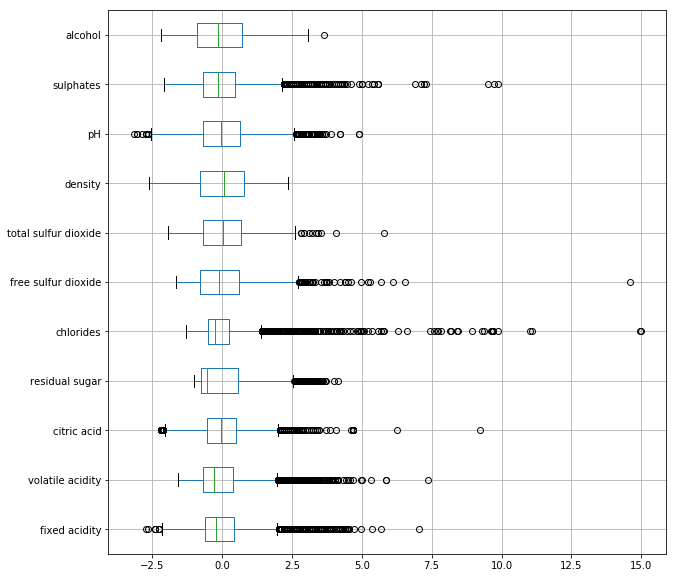

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerics = df.drop(['type', 'quality'], axis=1)
numerics[numerics.columns] = scaler.fit_transform(numerics)
numerics.boxplot(figsize=(10,10), vert=False)

In [14]:
df[df.chlorides == df.chlorides.max()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5156,0,7.7,0.41,0.76,1.8,0.611,8.0,45.0,0.9968,3.06,1.26,9.4,5


In [15]:
df[df['free sulfur dioxide'] == df['free sulfur dioxide'].max()] 

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4745,1,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


In [16]:
df.drop([5156, 4745], inplace=True)
df.shape

(5185, 13)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5185 entries, 0 to 6496
Data columns (total 13 columns):
type                    5185 non-null int8
fixed acidity           5185 non-null float64
volatile acidity        5185 non-null float64
citric acid             5185 non-null float64
residual sugar          5185 non-null float64
chlorides               5185 non-null float64
free sulfur dioxide     5185 non-null float64
total sulfur dioxide    5185 non-null float64
density                 5185 non-null float64
pH                      5185 non-null float64
sulphates               5185 non-null float64
alcohol                 5185 non-null float64
quality                 5185 non-null int64
dtypes: float64(11), int64(1), int8(1)
memory usage: 531.7 KB


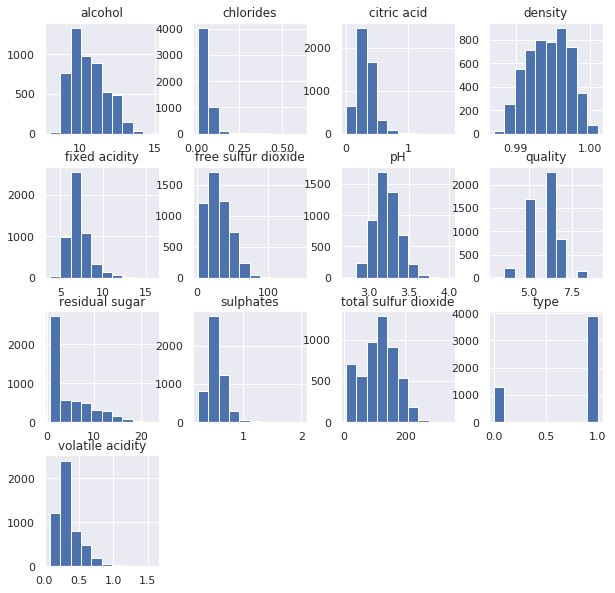

In [18]:
sns.set()
df.hist(figsize=(10,10))
plt.show()

In [19]:
df.quality.value_counts().sort_index()

3      27
4     204
5    1696
6    2267
7     839
8     147
9       5
Name: quality, dtype: int64

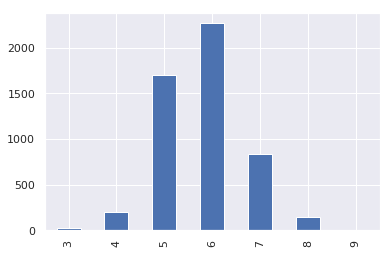

In [20]:
df.quality.value_counts().sort_index().plot.bar()

In [0]:
# a=df.copy()
# df = a.copy()
# df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff0cc70dd8>,
      dtype=object)

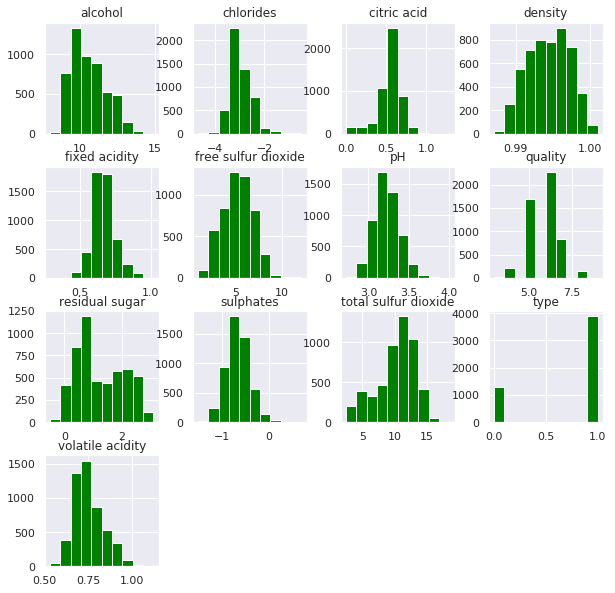

In [22]:
df.chlorides = df.chlorides.apply(np.log)
df['citric acid'] = df['citric acid'].apply(np.sqrt)
df['fixed acidity'] = df['fixed acidity'].apply(np.log)
df['free sulfur dioxide'] = df['free sulfur dioxide'].apply(np.sqrt)
df['residual sugar'] = df['residual sugar'].apply(np.log)
df.sulphates = df.sulphates.apply(np.log)
df['volatile acidity'] = df['volatile acidity'].apply(np.sqrt)
df['fixed acidity'] = df['fixed acidity'].apply(np.log)
df['total sulfur dioxide'] = df['total sulfur dioxide'].apply(np.sqrt)
df['volatile acidity'] = df['volatile acidity'].apply(np.sqrt)
df.hist(figsize=(10,10), color='green')

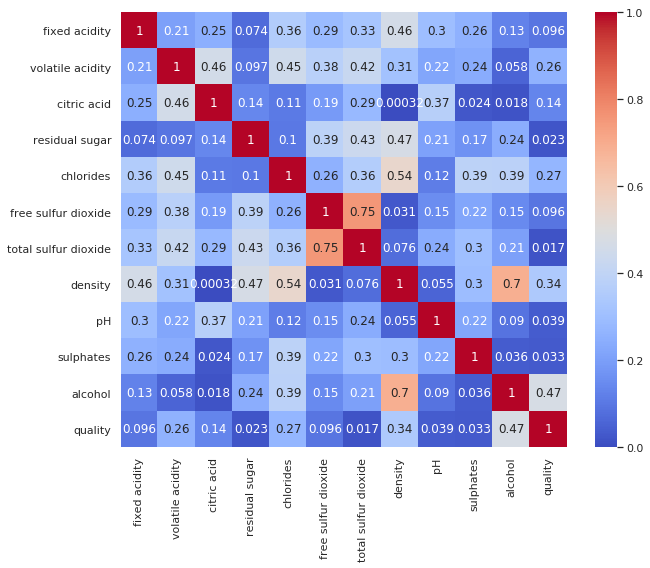

In [23]:
corr_matrix = df.drop('type', axis=1).corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

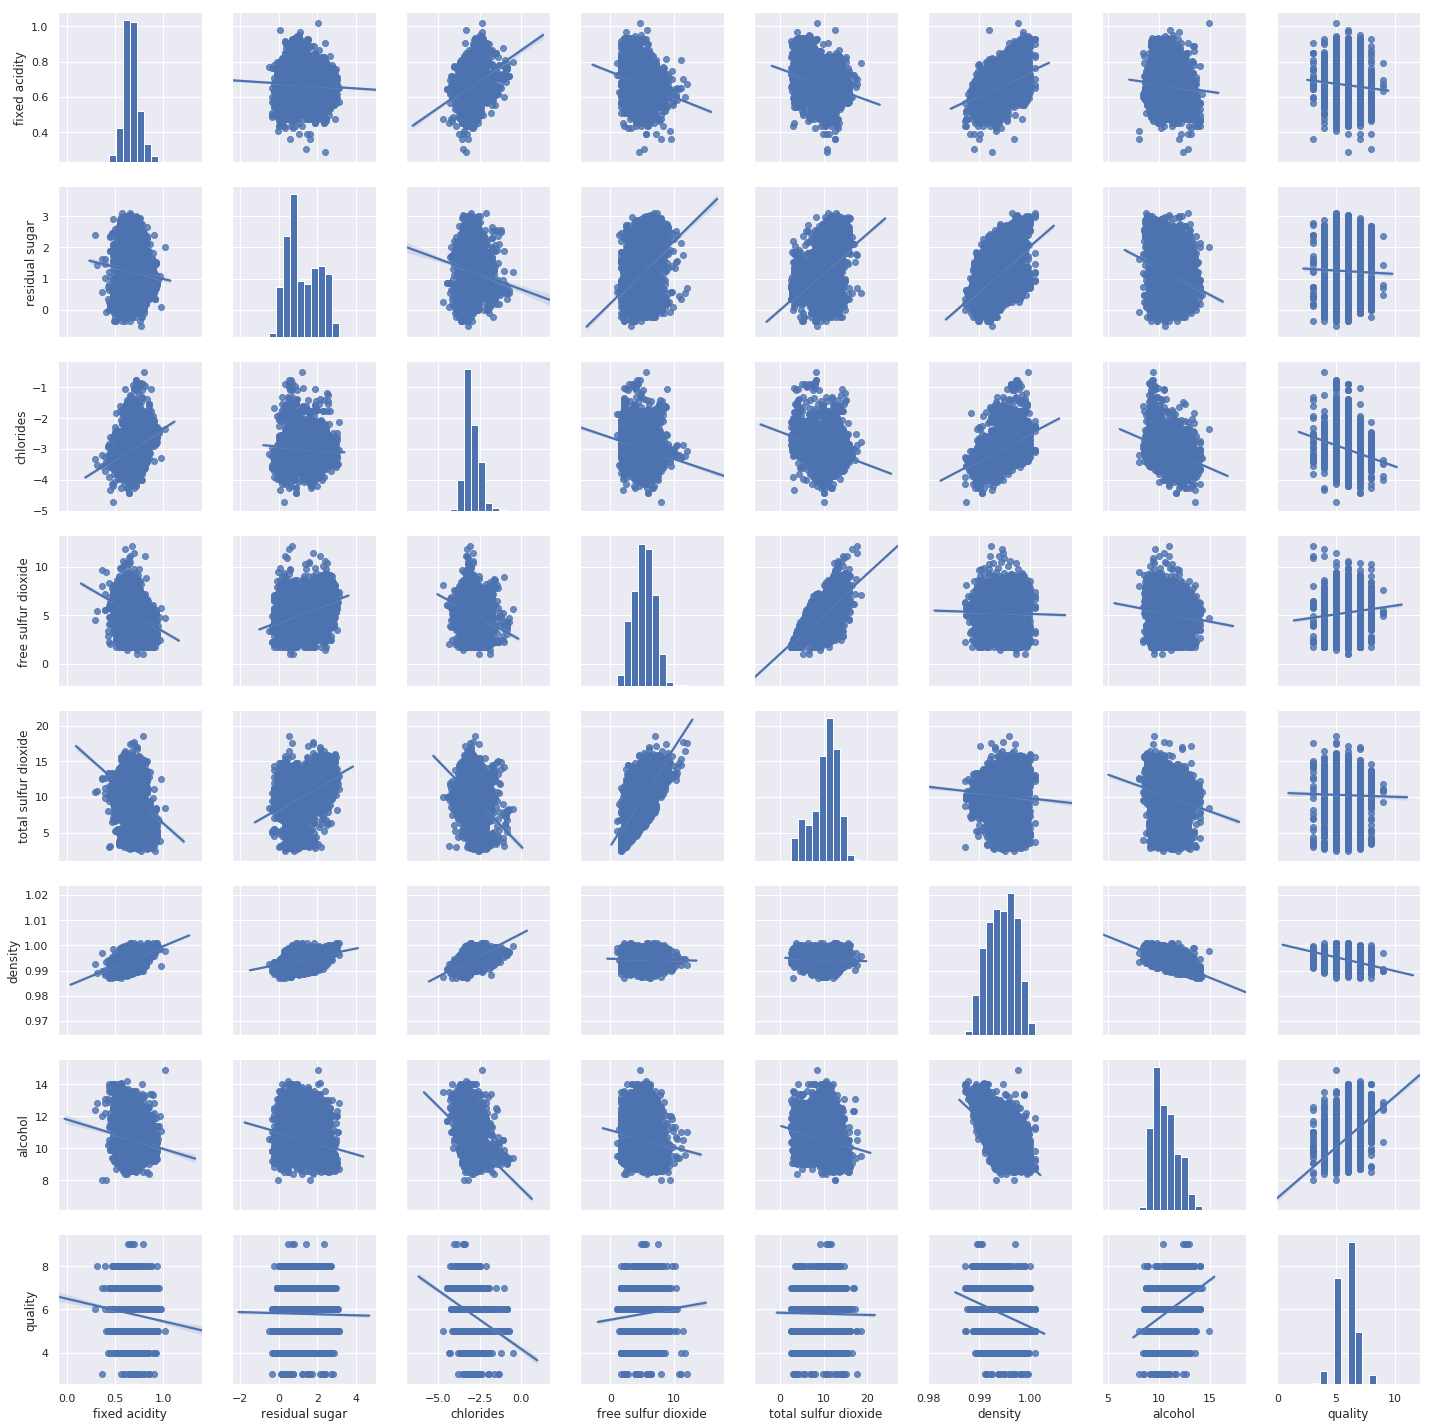

In [24]:
correlations = ['type', 'volatile acidity', 'citric acid', 'pH', 'sulphates']
sns.pairplot(df.drop(correlations, axis=1), kind="reg")

In [0]:
seed = 0
x = df.drop('quality', axis=1)
y = df.quality

In [0]:
from sklearn.feature_selection import SelectKBest, f_classif

In [0]:
def KBestTable(sel, df, features):
    names = df[features].columns.values[sel.get_support()]
    scores = pd.Series(sel.scores_, names).sort_values(ascending=False)
    return scores

In [28]:
sel = SelectKBest(f_classif, k = 'all').fit(x, y)
KBestTable(sel, x, x.columns)

alcohol                 305.989548
density                 142.570015
chlorides                80.904157
volatile acidity         79.008167
free sulfur dioxide      18.918279
citric acid              17.513621
type                     15.769494
fixed acidity             9.367327
total sulfur dioxide      6.267301
residual sugar            6.242351
sulphates                 3.870747
pH                        2.993552
dtype: float64

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
#pipeline 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split, StratifiedKFold
import time
#Classes para incrementação dos dicionários
from itertools import chain
from collections import defaultdict

In [0]:
#Função para Treinar e testar os modelos a partir dos nove classificares pré-selecionados
def clfs_train_test(clf, param, x_train, x_test, y_train, y_test):
    '''
    #clf = Classificadores
    #prm = Parâmetros para tuning
    #X_train = conjunto de produtos para treino
    #X_test = conjunto de produtos para teste
    #Y_train = conjunto de categorias para treino
    #Y_test = conjunto de categorias para teste
    '''

    skb = {'sel__k': ['all'] + list(range(3,len(x.columns),3))}
    param.update(skb)
  
    cv = StratifiedKFold(n_splits=5, random_state=seed)
    pipe = Pipeline(steps=[('sel', SelectKBest()), ('clf', clf)]) #Montagem do pipeline com suas etapas
    
    comeco = time.time() #Marcação da hora de início dos treinos
    model = GridSearchCV(pipe, param_grid=param, cv=cv, scoring='f1_weighted') #GridSearch para treino e teste das combinações de parâmetros
    model.fit(x_train, y_train) #Treino
    fim = time.time() #Marcação da hora de fim dos treinos
    tempo_treino= fim-comeco #Tempo em segundos para execução do treino
                     
    best_parameters = model.best_params_ #Melhores parâmetros para o respectivo classificador e conjunto de dados
    best_score = model.best_score_ #Maior score (f1 score) obtido
    best_model = model.best_estimator_ #Otimização do melhor modelo

    comeco = time.time() #Marcação da hora de início dos testes               
    pred = best_model.predict(x_test) #Teste
    fim = time.time() #Marcação da hora de fim dos treinos
    tempo_teste = fim-comeco #Tempo em segundos para execução do teste
    
    #Print dos principais resultados da função                 
    print("\n{}".format(clf.__class__.__name__)) #Nome do classificador
    print("\n--------------------")
    print("Tempo de treino: {}".format(tempo_treino))
    # print("Tempo de teste: {}".format(tempo_teste)) 
    print('A melhor combinação de parâmetros:')
    print(best_parameters)
    print("Maior F1-score: {}".format(best_score))
    print("F1-score de Teste: {}".format(model.score(x_test, y_test)))
    print('Reporte de classificação:')
    print(classification_report(y_test, pred))
    print("\n\n")
    
    #Lista com os principais resultados
    tempo_teste = 0
    resultado = {'nome':clf.__class__.__name__, 'tempo_treino':tempo_treino, 'best_score': best_score, 'score_treino':model.score(x_test, y_test)}
    
    return resultado, best_model

In [31]:
import warnings
warnings.filterwarnings("ignore")

clf1 = GaussianNB()
clf2 = DecisionTreeClassifier(random_state=seed)
clf3 = RandomForestClassifier(random_state=seed)
clf4 = MLPClassifier(random_state=seed)
clf7 = KNeighborsClassifier()
clf8 = SVC(random_state=seed)
clf9 = LogisticRegression()

#Definição dos parâmetros para tuning por classificador
prm1={}
prm2={'clf__max_depth':[None, 5, 10],'clf__min_samples_leaf':[1,20,50]}
prm3={'clf__n_estimators':[10,50,100],'clf__max_depth':[None, 5, 10],'clf__min_samples_leaf':[1,20,50]}
prm4={'clf__learning_rate_init':[0.001, 0.01], 'clf__max_iter':[200,500]}
prm7={'clf__n_neighbors': [3,5,10], 'clf__weights':['uniform', 'distance']}
prm8={'clf__C':[1,0.5], 'clf__shrinking':[False, True]}
prm9={'clf__solver':['sag'],'clf__multi_class':['multinomial'], 'clf__max_iter': [3,7]}

resultados = {} #Dicionário para armazenar os resultados da função clfs_train_test
resultados = defaultdict(list)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=seed)

#Looping para aplicar a função para todos os classificadores e parâmetros e armazenar os resultados no dicionário resultados
summary=[]
models = {}
for clf, prm in [[clf1,prm1], [clf2,prm2],[clf3,prm3],[clf4,prm4],[clf7,prm7],[clf8,prm8],[clf9,prm9]]:
  results, model = clfs_train_test(clf, prm, x_train, x_test, y_train, y_test)
  summary.append(results)
  models[results['nome']] = model

    #Looping para incrementar dicionários
    # for k, v in chain(resultados.items(), clfs_train_test(clf, prm, x, y).items()): 
    #   resultados[k].append(v)


GaussianNB

--------------------
Tempo de treino: 0.23488664627075195
A melhor combinação de parâmetros:
{'sel__k': 3}
Maior F1-score: 0.4696321771003185
F1-score de Teste: 0.46369031997361704
Reporte de classificação:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.02      0.05        41
           5       0.51      0.71      0.59       339
           6       0.50      0.45      0.47       454
           7       0.40      0.36      0.38       168
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00         1

    accuracy                           0.49      1037
   macro avg       0.34      0.22      0.21      1037
weighted avg       0.49      0.49      0.46      1037





DecisionTreeClassifier

--------------------
Tempo de treino: 3.4041011333465576
A melhor combinação de parâmetros:
{'clf__max_depth': 5, 'clf__min_samples_leaf': 50, 'sel__k': 'a

In [32]:
pd.DataFrame(summary, columns=['nome', 'best_score', 'score_treino', 'tempo_treino']).sort_values('score_treino', ascending=False)

,nome,best_score,score_treino,tempo_treino
2,RandomForestClassifier,0.542090,0.538976,95.219883
3,MLPClassifier,0.516114,0.527196,105.987608
4,KNeighborsClassifier,0.492165,0.518108,3.470331
1,DecisionTreeClassifier,0.490891,0.510081,3.404101
6,LogisticRegression,0.460407,0.492923,0.887271
5,SVC,0.490821,0.491792,56.423801
0,GaussianNB,0.469632,0.463690,0.234887


In [0]:
# !pip install -U pandas-profiling
# import pandas_profiling
# profile = df.profile_report()
# df.profile_report(style={'full_width':True})

In [0]:
# !pip install -U tensorflow

# import tensorflow as tf
# print(tf.__version__)

# from sklearn.model_selection import train_test_split 
# label = 'quality'
# X = df.drop([label, 'type'], axis=1)
# # X.type[X.type == 'White'] = 1
# # X.type[X.type == 'Red'] = 0
# y = encoder.fit_transform(df[[label]])
# X_train, X_test, y_train, y_test = train_test_split( 
#            X, y, test_size = 0.2, random_state = 42) 

# import tensorflow as tf
# from tensorflow import keras

# model = keras.Sequential([
#     keras.layers.Dense(11, activation ='relu', input_shape =(11, )),
#     keras.layers.Dense(9, activation ='relu'),
#     keras.layers.Dense(7, activation ='sigmoid')
# ])

# model.output_shape 
# model.summary() 
# model.get_config() 
  
# # List all weight tensors 
# model.get_weights() 
# model.compile(loss ='sparse_categorical_crossentropy',  
#   optimizer ='adam', metrics =['accuracy']) 

# from sklearn.preprocessing import LabelBinarizer
# encoder = LabelBinarizer()
# transfomed_label = encoder.fit_transform(y)
# transfomed_label

# model.fit(X_train, y_train, epochs = 3, 
#            batch_size = 1, verbose = 1) 
   
# # Predicting the Value 
# y_pred = model.predict(X_test) 
# print(y_pred)

---

## Conclusão

1. Quais variáveis impactam na qualidade do vinho?
1. Como foi a definição da sua estratégia de modelagem?
1. Como foi definida a função de custo utilizada?
1. Qual foi o critério utilizado na seleção do modelo final?
1. Qual foi o critério utilizado para validação do modelo? Por que escolheu utilizar
este método?
1. Quais evidências você possui de que seu modelo é suficientemente bom?

---

In [0]:
# Referencias
# http://www.uvibra.com.br/legislacao_portaria229.htm
# https://unsplash.com/
# https://blog.famigliavalduga.com.br/afinal-o-que-e-vinho-verde/
